In [1]:
from kalman_rpe import *

In [18]:
def make_1param_pygsti_Zmodel(x, gate_depolarization=0., spam_depolarization=0.):
    zunitary = make_noisy_z_unitary(x)
    model = smq1Q_XYZI.target_model(simulator='map')
    model['Gzpi2', 0] = pygsti.tools.unitary_to_superop(zunitary)
    model['Gxpi2', 0].depolarize(gate_depolarization)
    model['Gzpi2', 0].depolarize(gate_depolarization)
    model['rho0'].depolarize(spam_depolarization)
    model['Mdefault'].depolarize(spam_depolarization)
    return model

In [19]:
def pvec_from_circuits(x, circuits):
    model = make_1param_pygsti_Zmodel(x)
    pvec = np.zeros(len(circuits))
    for idx, circ in enumerate(circuits):
        pvec[idx] = model.probabilities(circ)['1']
    return pvec

def jacobian_from_circuits(x, circuits, epsilon=1e-6):
    jacob = np.zeros((len(circuits), 1))
    for idx, circ in enumerate(circuits):
        # calculate finite difference derivative
        x_plus = x.copy() + epsilon
        x_minus = x.copy() - epsilon
        p_plus = pvec_from_circuits(x_plus, [circ])
        p_minus = pvec_from_circuits(x_minus, [circ])
        jacob[idx] = (p_plus - p_minus) / (2*epsilon)
    return jacob

In [20]:
def simulate_experiment(x, circuit_list, shots_per_circuit=1000):
    model = make_1param_pygsti_Zmodel(x)
    return pygsti.data.simulate_data(model, circuit_list, num_samples=shots_per_circuit)

In [71]:
class KalmanFilter:
    """Extended Kalman filter of RPE data"""
    def __init__(self, x0, P0, save_history=False):
        self.x = x0.copy()
        self.P = P0.copy()
        self.save_history = save_history
        if save_history:
            self.xhistory = [self.x.copy()]
            self.Phistory = [self.P.copy()]

    def update(self, dataframe, num_shots, data_format="cartesian", estimated_gate_depol=0., estimated_spam_depol=0.):
        circuits = list(dataframe.keys())
        pvec = pvec_from_circuits(self.x, circuits)
        observation = np.array([dataframe[circ]['1'] for circ in circuits])/num_shots
        R = (0.25/num_shots)*np.eye(len(circuits))
        H = jacobian_from_circuits(self.x, circuits)
        K = self.P@H.T@np.linalg.inv(H@self.P@H.T + R)
        self.x = self.x + K@(observation - pvec)
        self.P = self.P - K@H@self.P
        if self.save_history:
            self.xhistory.append(self.x.copy())
            self.Phistory.append(self.P.copy())

    # def iterated_update(self, observation, d, num_shots, data_format="cartesian", estimated_gate_depol=0., estimated_spam_depol=0., tol=1e-8, max_iter=100):
    #     R = (0.25/num_shots)*np.eye(len(observation))
    #     x = self.x.copy()
    #     for i in range(0, max_iter):
    #         pvec = make_probability_vector(x, d)
    #         H = jacobian_from_circuits(x, d, estimated_gate_depol, estimated_spam_depol)
    #         K = self.P@H.T@np.linalg.inv(H@self.P@H.T + R)
    #         x_post = x + K@(observation - pvec)
    #         if np.linalg.norm(K@(observation - pvec)) < tol:
    #             self.x = x_post
    #             self.P = self.P - K@H@self.P
    #             if self.save_history:
    #                 self.xhistory.append(self.x.copy())
    #                 self.Phistory.append(self.P.copy())
    #             break
    #         elif i == max_iter - 1:
    #             print(f"WARNING: Max iterations reached without convergence with tolerance {tol}.")
    #             self.x = x_post
    #             self.P = self.P - K@H@self.P
    #             if self.save_history:
    #                 self.xhistory.append(self.x.copy())
    #                 self.Phistory.append(self.P.copy())
    #             break
    #         else:
    #             x = x_post


In [72]:
depths = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
z_rpe_cos_circuits = [make_z_cos_circuit(d) for d in depths]
z_rpe_sin_circuits = [make_z_sin_circuit(d) for d in depths]
xtrue = np.array([0.01])
dataset = simulate_experiment(xtrue, z_rpe_cos_circuits + z_rpe_sin_circuits, shots_per_circuit=1000)
estimates, last_good_gen = process_zgate_data(dataset, z_rpe_cos_circuits, z_rpe_sin_circuits, depths)
print(np.array(estimates)/4)

[0.0005     0.01007911 0.00808468 0.01127059 0.01064785 0.01046917
 0.01014702 0.01007991 0.01003934 0.00995818]


In [73]:
z_rpe_cos_circuits[1]

Circuit(Gzpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gzpi2:0@(0))

In [74]:
def dataset_to_dataframes(dataset, circuit_lists):
    dataframes = []
    for idx, circ_list in enumerate(circuit_lists):
        df = {}
        for circ in circ_list:
            df[circ] = dataset[circ].counts
        dataframes.append(df)
    return dataframes

In [75]:
dataframe_circuit_lists = [[cos]+[sin] for cos, sin in zip(z_rpe_cos_circuits, z_rpe_sin_circuits)]
dataframe = dataset_to_dataframes(dataset, dataframe_circuit_lists)

In [76]:
dataframe[1].items()

dict_items([(Circuit(Gzpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gzpi2:0@(0)), OutcomeLabelDict([(('0',), 995.0), (('1',), 5.0)])), (Circuit(Gzpi2:0Gzpi2:0Gzpi2:0Gxpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gzpi2:0Gxpi2:0@(0)), OutcomeLabelDict([(('0',), 540.0), (('1',), 460.0)]))])

In [77]:
x0 = np.zeros(1)
P0 = 0.1*np.eye(1)
kf = KalmanFilter(x0, P0, save_history=True)
for df in dataframe:
    kf.update(df, 1000)

In [79]:
kf.P

array([[1.78495479e-10]])

# multimodality testing: 


First, just plot the distribution of points drawn from the prior in observation space

In [115]:
def sample_observation_function(circ, x, P, num_samples):
    pvecs = []
    xs = []
    for i in range(num_samples):
        x_sample = np.random.multivariate_normal(x, P)
        pvec = pvec_from_circuits(x_sample, [circ])
        pvecs.append(pvec)
        xs.append(x_sample)
    return np.array(xs), np.array(pvecs)

def plot_sampled_observation_function(xs, pvecs):
    plt.scatter(xs, pvecs, alpha=0.1)
    plt.show()

def plot_observation_distribution(pvecs):
    # histogram of observations
    plt.hist(pvecs, bins=20)


In [136]:
x0 = [0.3]
P0 = [[0.01]]
num_samples = 1000
d = 6
xs_cos, pvecs_cos = sample_observation_function(z_rpe_cos_circuits[d], x0, P0, num_samples)
xs_sin, pvecs_sin = sample_observation_function(z_rpe_sin_circuits[d], x0, P0, num_samples)

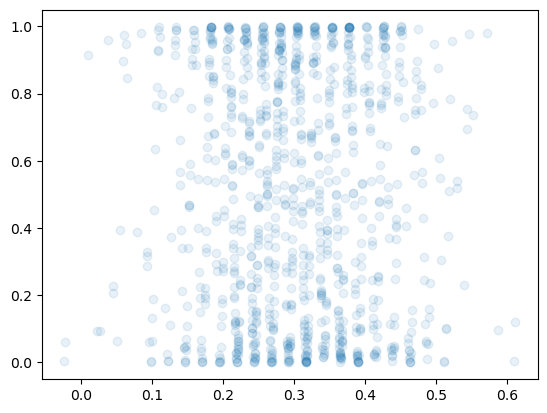

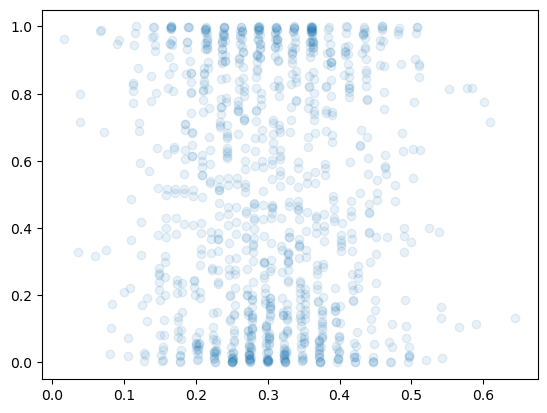

In [137]:
plot_sampled_observation_function(xs_cos, pvecs_cos)
plot_sampled_observation_function(xs_sin, pvecs_sin)

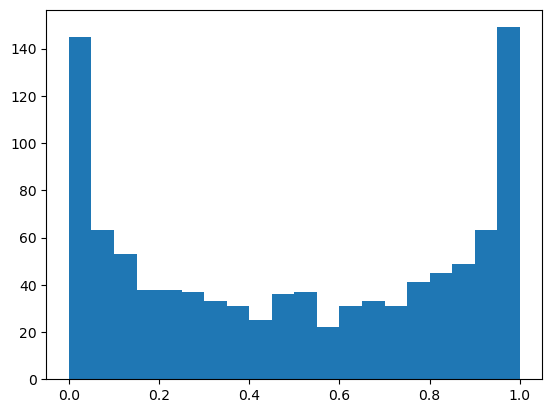

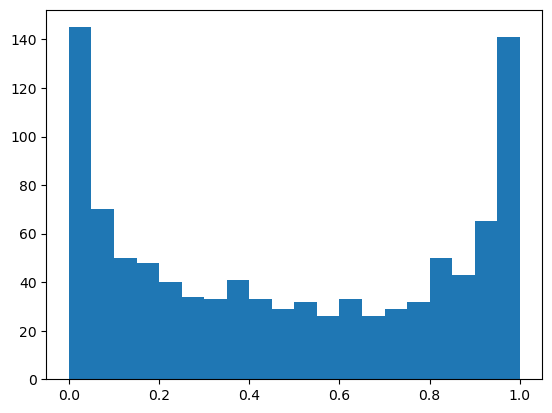

In [138]:
plot_observation_distribution(pvecs_cos)
plt.figure()
plot_observation_distribution(pvecs_sin)